In [42]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [43]:
import argparse
import torch
from torch import nn
import matplotlib.pyplot as plt
from stu import STU
import time
import random

In [44]:
from lds import *
from lds_utils import *
from lds_lr import LDS_LR
from lds_late import LDS_Late

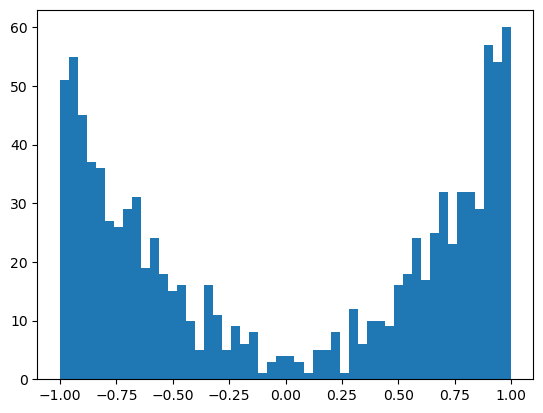

In [45]:
import matplotlib.pyplot as plt
_ = plt.hist(exponential_decay_init([1000], lam = 3), bins = 50)

In [54]:
layer_i = 0
state_dim = 10000
batch_size = 2
epochs = 4000
seq_len = 512
kx = 3
lam = 1
lr = 0.0001
rank = 100

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the layer i weights
stu_layer_full = torch.load(f"../stu_layers/stu_layer_{layer_i}_500m_param_full.pt", map_location=device)
stu_layer_full.to(device)

# Initialize LDS model
lds = LDS_LR(state_dim, 768, 768, kx, rank = rank, lam = lam).to(device)
# lds = LDS(state_dim, 768, 768, kx, lam = lam).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr=lr)

# Training
lds_loss_values = []

best_loss = float('inf')

/tmp/ipykernel_1289786/1072200449.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stu_layer_full = torch.load(f"../stu_layers/stu_layer_{layer_i}_500m_param_full.pt", m

In [55]:
import time

start_time = time.time()  # Start the timer

for epoch in range(epochs):
    inputs = torch.randn(batch_size, seq_len, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu_layer_full(inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min=-1)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    if epoch == 99:
        elapsed_time = time.time() - start_time
        print(f"Time taken for the first 100 epochs: {elapsed_time:.2f} seconds")

# Rank 768 is 66 seconds, Rank 50 is 16.76 seconds, normal LDS is 48 seconds
        
#With LDS_LR at rank = 50, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.086, 200 is 0.084, 300 is 0.082
#With LDS_LR at rank = 300, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.037, 200 is 0.02, 300 loss is 0.012
#With LDS_LR at rank = 768, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.008, 200 is 0.0015, 300 loss is 0.00086

#With LDS at rank = 768, kx = 3, state = 10k, lam = 1 after 100 epochs loss is 0.0033, 200 is 0.00075, 300 loss is 0.00047

Epoch 0, Loss: 0.1031392514705658
Epoch 10, Loss: 0.09581121802330017
Epoch 20, Loss: 0.09000585973262787
Epoch 30, Loss: 0.08589068055152893
Epoch 40, Loss: 0.08211123198270798
Epoch 50, Loss: 0.07987412065267563
Epoch 60, Loss: 0.0781223401427269
Epoch 70, Loss: 0.07697010040283203
Epoch 80, Loss: 0.07513438165187836
Epoch 90, Loss: 0.07450686395168304
Time taken for the first 100 epochs: 21.83 seconds
Epoch 100, Loss: 0.0737910345196724
Epoch 110, Loss: 0.07290282845497131
Epoch 120, Loss: 0.07182840257883072
Epoch 130, Loss: 0.07127662748098373
Epoch 140, Loss: 0.07053793221712112
Epoch 150, Loss: 0.0697772204875946
Epoch 160, Loss: 0.06888589262962341
Epoch 170, Loss: 0.06838337332010269
Epoch 180, Loss: 0.06815819442272186
Epoch 190, Loss: 0.06722655147314072
Epoch 200, Loss: 0.0665038675069809
Epoch 210, Loss: 0.06631749868392944
Epoch 220, Loss: 0.0661069005727768
Epoch 230, Loss: 0.06504436582326889
Epoch 240, Loss: 0.06455492228269577
Epoch 250, Loss: 0.06435611844062805
Epoc

In [47]:
# torch.save(lds.state_dict(), "lds_10k_0.pth")
state_dict = torch.load('lds_10k_0.pth')
lds.load_state_dict(state_dict)

/tmp/ipykernel_1289786/3017131332.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('lds_10k_0.pth')


<All keys matched successfully>

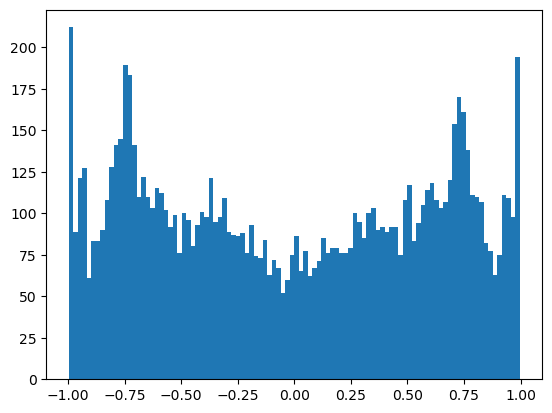

In [48]:
_ = plt.hist(lds.A.cpu().detach(), bins = 100)

In [50]:
loss = lds.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
print(loss.item())

0.0001138058869400993


In [52]:
lds_lr = LDS_LR.from_lds(lds, rank = 100).to(device)

inputs = torch.randn(5, 100, 768).to(device).to(torch.bfloat16)
stu_outputs = stu_layer_full(inputs).to(device)

loss = lds_lr.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)
print(loss.item())

0.05425967276096344


In [40]:
lds_output = lds(inputs.to(torch.float32))
lds_lr_output = lds_lr(inputs.to(torch.float32))

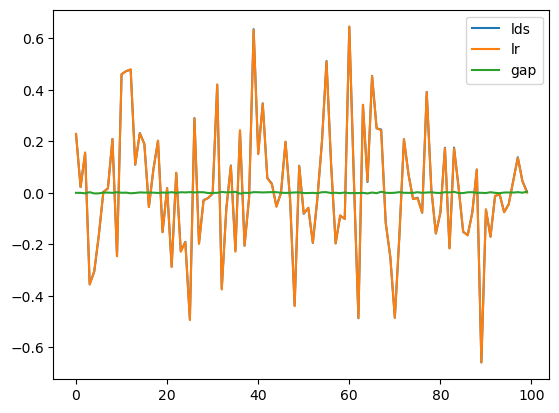

In [41]:
coord = 24
plt.plot(lds_output[0, :, coord].cpu().detach(), label = 'lds')
plt.plot(lds_lr_output[0, :, coord].cpu().detach(), label = 'lr')
plt.plot(lds_output[0, :, coord].cpu().detach() - lds_lr_output[0, :, coord].cpu().detach(), label = 'gap')
plt.legend()
plt.show()

In [82]:
import pandas as pd
from itertools import product
import tqdm

results = []

rank_range = range(50, 761, 100)

for rank_b, rank_c, rank_m in tqdm.tqdm(product(rank_range, repeat=3)):
    start_time = time.time()

    lds_lr = LDS_LR.from_lds(lds, ranks=[rank_b, rank_c, rank_m]).to(device)

    inputs = torch.randn(5, 100, 768).to(device).to(torch.bfloat16)
    stu_outputs = stu_layer_full(inputs).to(device)

    loss = lds_lr.compute_loss(inputs.to(stu_outputs.dtype), stu_outputs)

    elapsed_time = time.time() - start_time

    results.append({
        'rank_b': rank_b,
        'rank_c': rank_c,
        'rank_m': rank_m,
        'loss': loss.item(),
        'time': elapsed_time
    })

results_df = pd.DataFrame(results)

512it [05:53,  1.45it/s]


ModuleNotFoundError: No module named 'ace_tools'

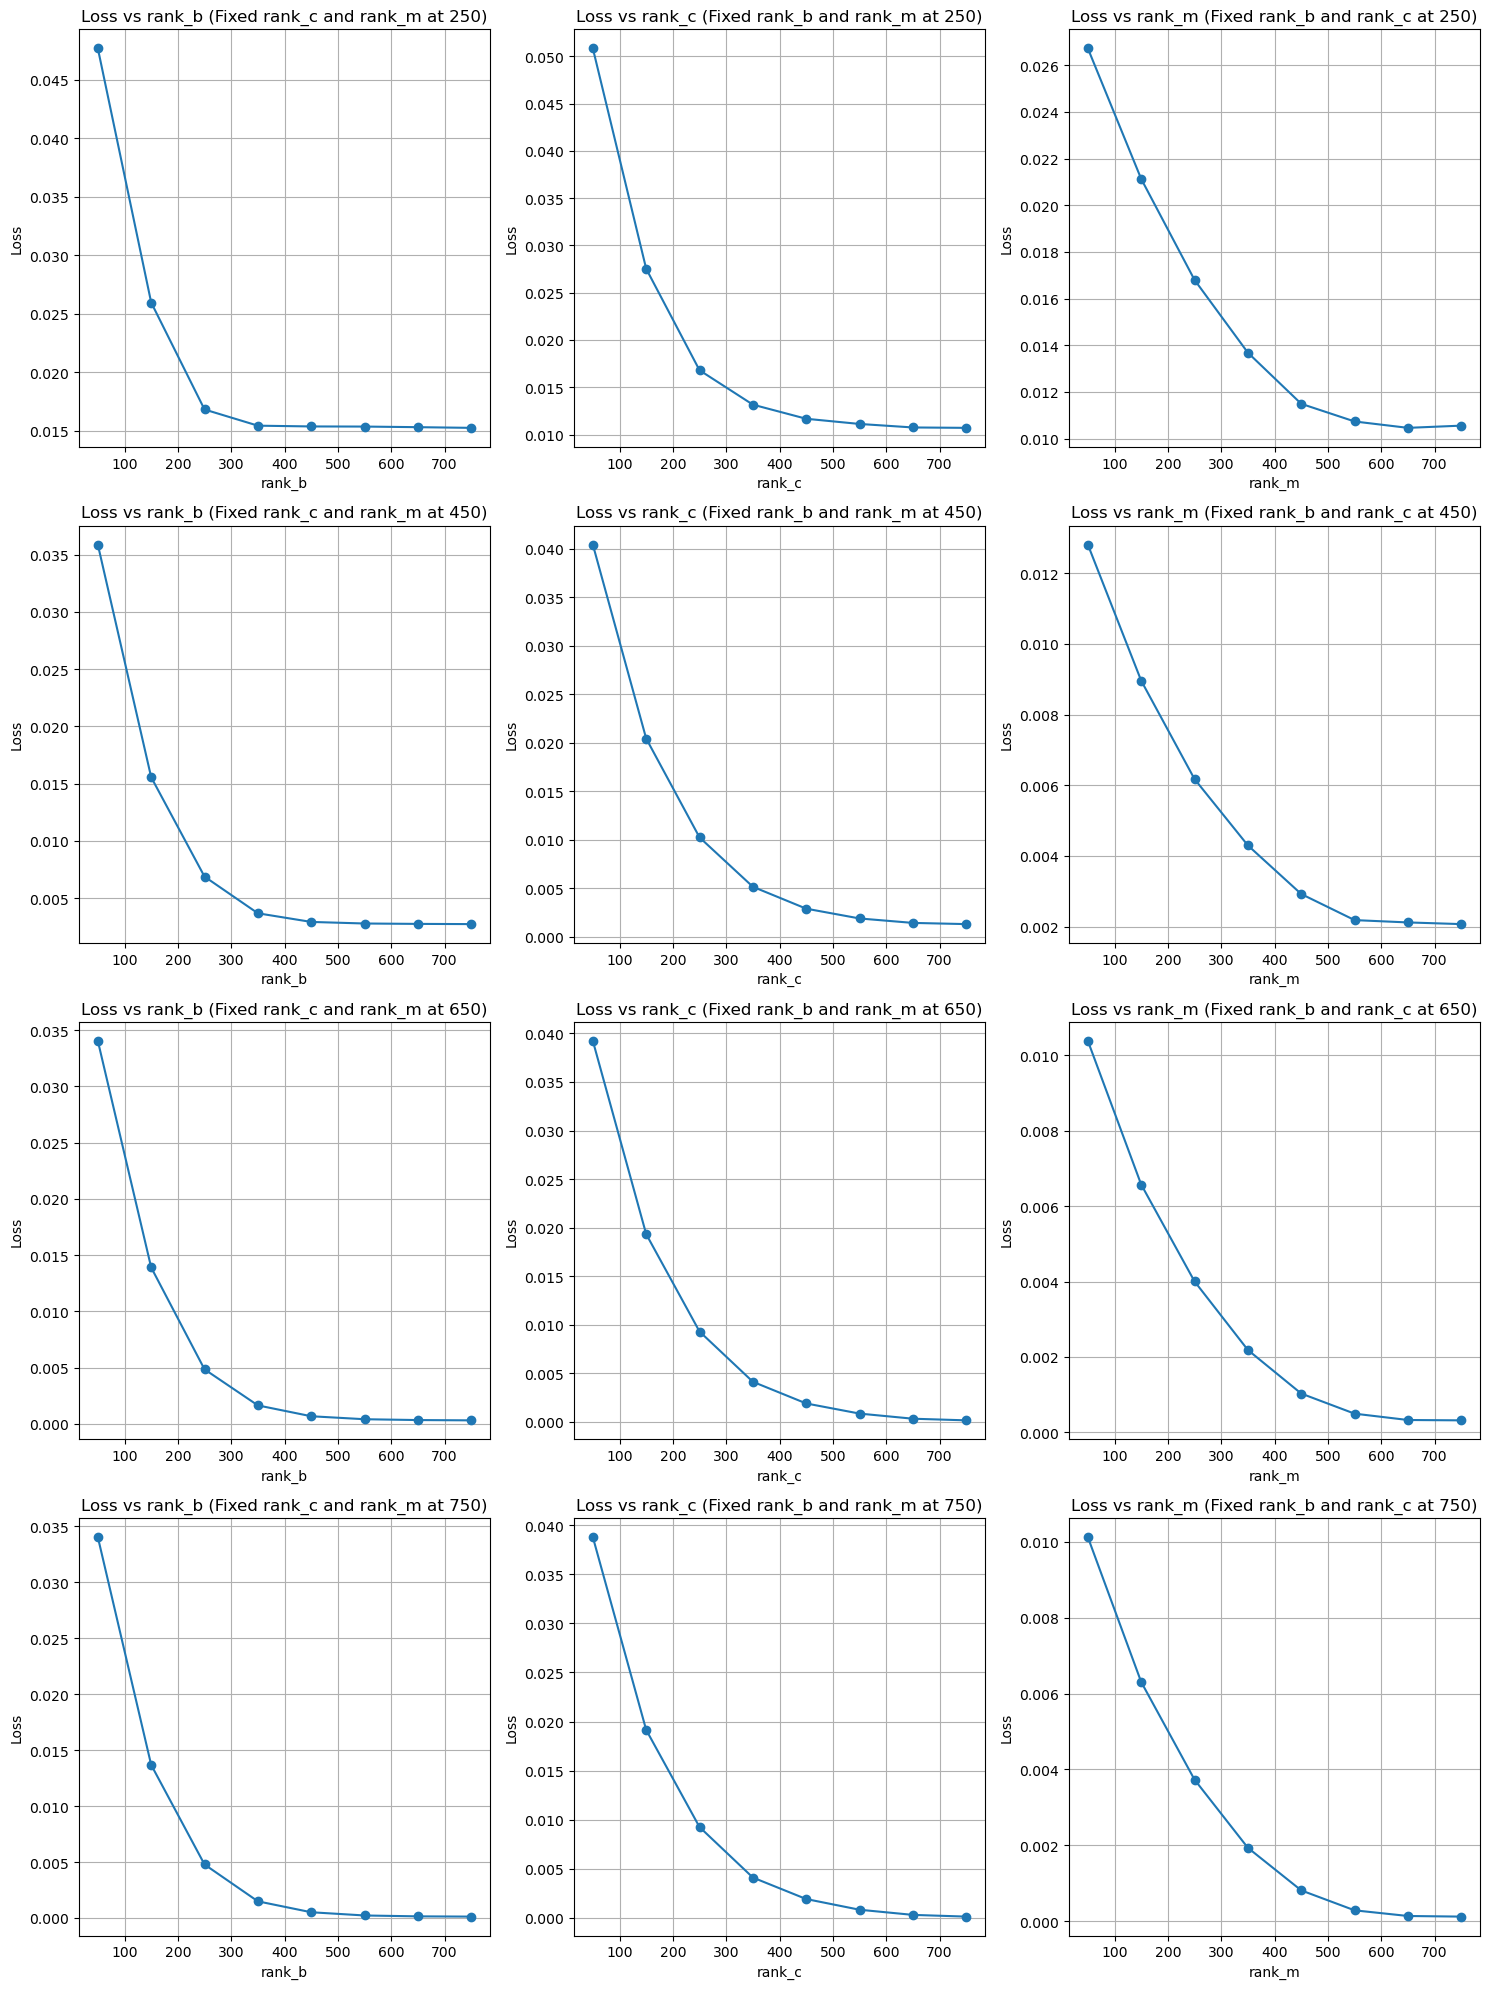

In [92]:
fixed_ranks = [250, 450, 650, 750]

fig, axs = plt.subplots(len(fixed_ranks), 3, figsize=(15, 5 * len(fixed_ranks)))

for i, fixed_rank in enumerate(fixed_ranks):
    for j, varying_rank in enumerate(['rank_b', 'rank_c', 'rank_m']):
        fixed_columns = [col for col in ['rank_b', 'rank_c', 'rank_m'] if col != varying_rank]
        filtered_df = results_df[(results_df[fixed_columns[0]] == fixed_rank) & (results_df[fixed_columns[1]] == fixed_rank)]

        axs[i, j].plot(filtered_df[varying_rank], filtered_df['loss'], marker='o')
        axs[i, j].set_title(f'Loss vs {varying_rank} (Fixed {fixed_columns[0]} and {fixed_columns[1]} at {fixed_rank})')
        axs[i, j].set_xlabel(varying_rank)
        axs[i, j].set_ylabel('Loss')
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()
